# 一个关于LSTM生成歌词的练习

这是一个练习笔记，不会有LSTM的原理说明，并且其中可能存在各种错误

# 导入各种包

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM
from keras.utils import to_categorical
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.preprocessing.sequence import pad_sequences

%matplotlib inline

Using TensorFlow backend.


# 数据

这是关于王力宏的歌词excel文件，包含91首歌，共2列属性：歌曲名（Title），歌词（Lyrics）

In [2]:
file_path = '../input/wanglihong/wanglihong.xlsx'
songs = pd.read_excel(file_path)
print(songs.shape)
songs.head()

(91, 2)


,Title,Lyrics
0,Bridge of Faith,秦时明月汉时关 万里长征人未还 但使龙城飞将在 不教胡马度阴山 狼烟千里乱葬岗 乱世孤魂无人...
1,DO U Love Me,眼睛看我 看看我的眼睛 想问问你 问你一个问题 你你我我 还在演什么戏 戏如人生 还是人生如...
2,Dragon Dance,原来默罕默德就是杜明汉 杜杜杜杜~汉 额 这就叫做用丹田唱歌 他根本就不会用丹田唱歌 他...
3,FLOW,跟着我Flow 跟着我Flow 这么自由 这么自由 Yi Li A E Yi Li A O ...
4,Happiness x 3 Loneliness x 3,happiness happiness happiness loneliness lonel...


查看前五首歌的歌词内容

In [3]:
for i in range(5):
    print(i, '\n', songs['Lyrics'][i])

0 
 秦时明月汉时关 万里长征人未还 但使龙城飞将在 不教胡马度阴山 狼烟千里乱葬岗 乱世孤魂无人访 无言苍天笔墨寒 笔刀春秋以血偿 谈爱恨 不能潦草 战鼓敲啊敲 用信任 立下誓言我来熬 这缘分 像一道桥 旌旗飘啊飘 你想走 就请立马抽刀 爱一笔勾销 谈爱恨 不能潦草 红尘烧啊烧 以生死 无愧证明谁重要 这缘分 像一道桥 故事瞧一瞧 走天涯 你我卸下战袍 梦回长城谣 秦时明月汉时关 万里长征人未还 但使龙城飞将在 不教胡马度阴山 血肉筑城万箭穿 盔甲染血映月光 远方胡笳催断肠 狼嚎骤起震边关 谈爱恨 不能潦草 战鼓敲啊敲 用信任 立下誓言我来熬 这缘分 像一道桥 旌旗飘啊飘 你想走 就请立马抽刀 爱一笔勾销 谈爱恨 不能潦草 红尘烧啊烧 以生死 无愧证明谁重要 这缘分 像一道桥 故事瞧一瞧 走天涯 你我卸下战袍 梦回长城谣 这缘分 像一道桥 故事瞧一瞧 走天涯 你我卸下战袍 梦回长城谣 
1 
 眼睛看我 看看我的眼睛 想问问你 问你一个问题 你你我我 还在演什么戏 戏如人生 还是人生如戏 你爱的人到底是不是我 是否真正的我 是另一个样子 如果你愿意 我卸下我的面具 给你我全部 全部的我都给你 你挑着担 我牵着马 迎来日出 送走晚霞 给我一个反应 喊喊我的名字 美猴王的魅力 推前浪的行着 还在努力找传说中的幸福 一句道白 让你听的清楚 Do U Love Me 说说 你爱我到什么程度 Do U Want Me 说说 你要我到什么地步 让我相信 你的动心 为什么我还是 无法觉得真心 DoDoDoDoDoDoDoDo DoDoDoDo Do U Love Me 眼睛看我 看看我的眼睛 想问问你 问你一个问题 你你我我 还在演什么戏 戏如人生 还是人生如戏 你爱的人到底是不是我 是否真正的我 是另一个样子 如果你愿意 我卸下我的面具 给你我全部 全部的我都给你 你挑着担 我牵着马 迎来日出 送走晚霞 给我一个反应 喊喊我的名字 美猴王的魅力 推前浪的行着 还在努力找传说中的幸福 一句道白 让你听的清楚 Do U Love Me 说说 你爱我到什么程度 Do U Love Me 说说 你要我到什么地步 让我相信 你的动心 为什么我还是 无法觉得真心 DoDoDoDoDoDoDoDo DoDoDoDo Do U Love Me? Do U Love Me 说说 你爱我到什么

## 正则表达式

### 以第三首歌为例

英文，符号不要

In [4]:
song = re.sub(r"[a-zA-Z()''…?.，!！,-]+", '', songs['Lyrics'][3])
song

'跟着我 跟着我 这么自由 这么自由         跟着我 跟着我           一听到  我双脚开始 当节奏开始转 是谁都能感受 那音符一起玩 我停不下来 我简直停不下来 从头到脚趾头 没有理由有点儿奇怪       节奏轻轻地甩 微妙地笑 酷酷的跳 这是新的 不如你一起来加入 跟着我  我手指开始 跟着我  我弹指开始 这么自由       那韵律开始    这么自由       我们都开始   我们都开始 歌声多清切 灵感开始倾泻 的一种感觉     感觉多强烈 不需要详解 相同当中总有分别 两种风格的交接              一听到  我双脚开始 当节奏开始转 是谁都能感受 那音符一起玩 我停不下来 我简直停不下来 跟着我  我手指开始 跟着我  我弹指开始 这么自由       那韵律开始 这么自由       我们都开始 我们都开始           一听到  我双脚开始 我双脚开始 当节奏开始转 是谁都能感受 那音符一起玩 我停不下来 我简直停不下来           一听到  我双脚开始 当节奏开始转 是谁都能感受 那音符一起玩 我停不下来 我简直停不下来 跟着我  跟着我 跟着我  跟着我 这么自由       这么自由  这么自由       这么自由 跟着我 跟着我 这么自由 这么自由 '

空格太多，不要！只留一个空格

In [5]:
re.sub('\s{2,}', ' ', song)

'跟着我 跟着我 这么自由 这么自由 跟着我 跟着我 一听到 我双脚开始 当节奏开始转 是谁都能感受 那音符一起玩 我停不下来 我简直停不下来 从头到脚趾头 没有理由有点儿奇怪 节奏轻轻地甩 微妙地笑 酷酷的跳 这是新的 不如你一起来加入 跟着我 我手指开始 跟着我 我弹指开始 这么自由 那韵律开始 这么自由 我们都开始 我们都开始 歌声多清切 灵感开始倾泻 的一种感觉 感觉多强烈 不需要详解 相同当中总有分别 两种风格的交接 一听到 我双脚开始 当节奏开始转 是谁都能感受 那音符一起玩 我停不下来 我简直停不下来 跟着我 我手指开始 跟着我 我弹指开始 这么自由 那韵律开始 这么自由 我们都开始 我们都开始 一听到 我双脚开始 我双脚开始 当节奏开始转 是谁都能感受 那音符一起玩 我停不下来 我简直停不下来 一听到 我双脚开始 当节奏开始转 是谁都能感受 那音符一起玩 我停不下来 我简直停不下来 跟着我 跟着我 跟着我 跟着我 这么自由 这么自由 这么自由 这么自由 跟着我 跟着我 这么自由 这么自由 '

很好，写成函数形式

In [6]:
def regex_func(text):
    text = re.sub(r"[a-zA-Z()''…?.，!！,-]+", '', text)
    text = re.sub('\s{2,}', ' ', text)
    return text

## 新建一个DataFrame

In [7]:
new_songs = pd.DataFrame(columns=songs.columns)
new_songs['Title'] = songs['Title']

将正则函数用于歌词，并且添加一个包含歌词长度的属性

In [8]:
length = []
for i in range(len(new_songs)):
    new_songs.loc[i]['Lyrics'] = regex_func(songs['Lyrics'][i])
    length.append(len(new_songs['Lyrics'][i]))
new_songs['Length'] = length
new_songs.head()

,Title,Lyrics,Length
0,Bridge of Faith,秦时明月汉时关 万里长征人未还 但使龙城飞将在 不教胡马度阴山 狼烟千里乱葬岗 乱世孤魂无人...,396
1,DO U Love Me,眼睛看我 看看我的眼睛 想问问你 问你一个问题 你你我我 还在演什么戏 戏如人生 还是人生如...,490
2,Dragon Dance,原来默罕默德就是杜明汉 杜杜杜杜~汉 额 这就叫做用丹田唱歌 他根本就不会用丹田唱歌 他根本...,271
3,FLOW,跟着我 跟着我 这么自由 这么自由 跟着我 跟着我 一听到 我双脚开始 当节奏开始转 是谁都...,458
4,Happiness x 3 Loneliness x 3,你似乎看见大楼阴影复活包围过来 自由到不自在期待的色彩都成了黑白 谁是你的朋友谁是你的真爱...,200


现在拥有一个较干净的数据了，接下来可以搞 · 事 · 情了

# 输入输出1

取窗口长度为10，窗口步长为1，即输入字符串“秦时明月汉时关 万里”，然后输出“长”；输入“时明月汉时关 万里长”，然后输出“征”，不断地滑向下一个汉字，如此类推，这就是所谓的滑窗(Sliding Window)，如下图：

|输入|输出|
|--|--|
|秦时明月汉时关 万里|长|
|时明月汉时关 万里长|征|
|明月汉时关 万里长征|人|
|月汉时关 万里长征人|未|
|汉时关 万里长征人未|还|

接下来将汉字转化为数值类型

# 序列化

In [9]:
n = len(new_songs) # 歌曲总数目
print('一共有{}首歌'.format(n))

一共有91首歌


将所有歌词合并成一个长长的字符串

In [10]:
texts = ''
for i in range(n):
    texts += new_songs['Lyrics'][i]
print('所有歌词的总长度:', len(texts))

所有歌词的总长度: 33575


## 使用Keras

使用Tokenizer()将文本转换为序列，即转为整数

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

每个字（当然不止汉字，可能还有其它奇奇怪怪的符号，以下统称汉字）对应的下标，返回字典形式——汉字：下标

In [ ]:
tokenizer.word_index # 返回按字频降序排序的字典 {'的': 1, '我': 2, '你': 3, '不': 4, '是': 5, '一': 6, '爱': 7, ...}

每个字的出现频率频，返回字典形式——汉字：频率。以下简称：字频

In [ ]:
tokenizer.word_counts # 返回 OrderedDict([('秦', 2),('时', 93),('明', 62),('月', 35),('汉', 4),('关', 17), ...])

查看字典的长度

In [12]:
print('字典的长度：', len(tokenizer.word_counts))

字典的长度： 1636


使用texts_to_sequences将汉字映射为整数序列

In [13]:
sequences = tokenizer.texts_to_sequences(texts)

In [14]:
# print('"', texts[: 10],'"',  '分别被映射成了数字：')
print('"{}"{}'.format(texts[: 10], '分别被映射成了整数：'))
print(sequences[: 10])

"秦时明月汉时关 万里"分别被映射成了整数：
[[1062], [46], [87], [171], [805], [46], [341], [], [220], [31]]


然而我们所写的歌词并不需要使用字典里所有的汉字，有些字只出现一两次，所以考虑可以忽略掉

tokenizer()中提供了参数num_words，在使用时，取字频最多的前(num_words-1)个汉字，多余的为空集，但字典的长度还是和原来的一样

In [15]:
num_words = 400
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(texts)
print('字典的长度：', len(tokenizer.word_index))

字典的长度： 1636


In [16]:
sequences = tokenizer.texts_to_sequences(texts)
print('"{}"{}'.format(texts[: 10], '分别被映射成了整数：'))
print(sequences[: 10])

"秦时明月汉时关 万里"分别被映射成了整数：
[[], [46], [87], [171], [], [46], [341], [], [220], [31]]


对比上面两个sequences的结果来看，第二个sequences里出现了更多的空列表，这就代表了num_words发挥了作用  


### Pad_sequences

> pad_sequences(sequences, maxlen=None, padding='pre', truncating='pre', value=0.0)
* sequences: 列表的列表，每一个元素是一个序列。
* maxlen: 整数，所有序列的最大长度。
* padding: 字符串，'pre' 或 'post' ，在序列的前端补齐还是在后端补齐。
* truncating: 字符串，'pre' 或 'post' ，移除长度大于 maxlen 的序列的值，要么在序列前端截断，要么在后端。
* value: 浮点数，表示用来补齐的值。

接着使用 pad_sequences 对空值进行填补

In [17]:
sequences = pad_sequences(sequences)
sequences[: 10]

array([[  0],
       [ 46],
       [ 87],
       [171],
       [  0],
       [ 46],
       [341],
       [  0],
       [220],
       [ 31]], dtype=int32)

In [18]:
print('最小索引：{}，最大索引：{}'.format(sequences.min(), sequences.max()))

最小索引：0，最大索引：399


于是sequences里的索引对应了num_words=400，我们之后使用的汉字只有这400个字

## 新增列

这一列是将每首歌的歌词映射为整数序列后新的一列

In [19]:
star = 0
end = 0
new_songs['Sequences'] = ''
for i in range(n):
    end += new_songs['Length'][i]
    new_songs.loc[i, 'Sequences'] = sequences[star: end]
    star = end
new_songs.head()

,Title,Lyrics,Length,Sequences
0,Bridge of Faith,秦时明月汉时关 万里长征人未还 但使龙城飞将在 不教胡马度阴山 狼烟千里乱葬岗 乱世孤魂无人...,396,"[0, 46, 87, 171, 0, 46, 341, 0, 220, 31, 212, ..."
1,DO U Love Me,眼睛看我 看看我的眼睛 想问问你 问你一个问题 你你我我 还在演什么戏 戏如人生 还是人生如...,490,"[49, 229, 39, 2, 0, 39, 39, 2, 1, 49, 229, 0, ..."
2,Dragon Dance,原来默罕默德就是杜明汉 杜杜杜杜~汉 额 这就叫做用丹田唱歌 他根本就不会用丹田唱歌 他根本...,271,"[263, 18, 389, 0, 389, 0, 14, 5, 0, 87, 0, 0, ..."
3,FLOW,跟着我 跟着我 这么自由 这么自由 跟着我 跟着我 一听到 我双脚开始 当节奏开始转 是谁都...,458,"[150, 33, 2, 0, 150, 33, 2, 0, 11, 13, 26, 139..."
4,Happiness x 3 Loneliness x 3,你似乎看见大楼阴影复活包围过来 自由到不自在期待的色彩都成了黑白 谁是你的朋友谁是你的真爱...,200,"[0, 3, 0, 359, 39, 57, 86, 0, 0, 360, 0, 348, ..."


In [ ]:
new_songs['Sequences'][0][: 15]

# 输入输出2

这时候拥有了数值型的数据，输入一个序列，输出下一个值：

|输入|输出|
|--|--|
|[0, 46, 87, 171, 0, 46, 341, 0, 220, 31]|[212]|
|[46, 87, 171, 0, 46, 341, 0, 220, 31, 212]|[0]|
|[87, 171, 0, 46, 341, 0, 220, 31, 212, 0]|[15]|
|[171, 0, 46, 341, 0, 220, 31, 212, 0, 15]|[127]|
|[0, 46, 341, 0, 220, 31, 212, 0, 15, 127]|[43]|

接下来进行滑窗的处理

# 滑窗

由于每首歌之间的歌词是没有联系的，并不会从一首歌的歌词预测到另一首歌的歌词，所以不能直接使用整个texts来滑窗划分，而是分别对每首歌进行处理

### 以第一首歌为例

In [20]:
seq = new_songs['Sequences'][0]
seq[: 10]

[0, 46, 87, 171, 0, 46, 341, 0, 220, 31]

取滑窗的长度为10，也就是之后神经网络的输入序列的长度

In [21]:
max_len = 10 # 滑窗长度，也就是输入序列的长度
len_lrc = new_songs['Length'][0] # 每首歌歌词的长度
X = []
y = []
for i in range(len_lrc - (max_len+1)):
    X.append(seq[i: i + (max_len+1)])
    y.append(seq[i + (max_len+1)])

得到了第一首歌的 X，y

In [ ]:
X
# 返回
# [[0, 46, 87, 171, 0, 46, 341, 0, 220, 31, 212],
# [46, 87, 171, 0, 46, 341, 0, 220, 31, 212, 0],
# [87, 171, 0, 46, 341, 0, 220, 31, 212, 0, 15],
# [171, 0, 46, 341, 0, 220, 31, 212, 0, 15, 127],
# [0, 46, 341, 0, 220, 31, 212, 0, 15, 127, 43],
# ...]

In [ ]:
y # 返回[0, 15, 127, 43,0 , 142, ...]

### 函数形式

In [22]:
# 这里是先将X，y合并成一个大矩阵，那么大矩阵的shape=(?, 11)
def build_matrix(sequence, max_len = 10):
    max_len += 1
    matrix = []
    length = len(sequence)
    for i in range(length - max_len):
        matrix.append(sequence[i: i + max_len])
    matrix = np.array(matrix)
    X = matrix[:, :-1]
    y = matrix[:, -1]
    return X, y

### 序列合并

In [23]:
# n = 91 歌曲数目
X, y = build_matrix(new_songs['Sequences'][0])
for i in range(1, n):
    sequence = new_songs['Sequences'][i]
    XX, yy = build_matrix(sequence)
    X = np.concatenate([X, XX])
    y = np.concatenate([y, yy])

得到了所有歌词的 X，y

In [ ]:
X
# 返回
# array([[  0,  46,  87, ...,   0, 220,  31],
#        [ 46,  87, 171, ..., 220,  31, 212],
#        [ 87, 171,   0, ...,  31, 212,   0],
#        ...,
#        [  3,   0, 268, ...,  52,  52,   1],
#        [  0, 268,  49, ...,  52,   1,   0],
#        [268,  49,   0, ...,   1,   0, 268]])

In [ ]:
y # 返回 array([212,   0,  15, ...,   0, 268,  49])

In [24]:
X.shape, y.shape

((32574, 10), (32574,))

一共得到32574行的输入序列

# 输入输出3

将输入序列进行字向量化（此处为单个汉字，故称字向量，而使用更多的为词向量），输出进行One hot编码，例如（数值是瞎写的）：

|整数|One Hot|字向量|
|--|--|--|
|3|[0, 0, 0, 1, 0, 0]|[0.32, 0.11]|
|6|[1, 0, 0, 0, 0, 0]|[0.51, 0.62]||
|4|[0, 0, 1, 0, 0, 0]|[0.26, 0.41]|

# 模型


在Keras里面，使用嵌入层 Embedding 可以输入进行向量化

> Embedding(input_dim, out_dim, input_length=None)  
* input_dim:大或等于0的整数，字典长度，即输入数据最大下标+1
* out_dim:大于0的整数，代表全连接嵌入的维度  
* input_length:当输入序列的长度固定时，该值为其长度

现在可以举个例子，拿 X[: 1] 来做示范

In [25]:
print('X[: 1]是', X[: 1].shape, '矩阵')
print('它含有数值：', X[: 1])

X[: 1]是 (1, 10) 矩阵
它含有数值： [[  0  46  87 171   0  46 341   0 220  31]]


Embedding 层 input_dim 就是所使用汉字的数目 num_words，out_dim 就是我们需要让整数向量化后的长度，input_length 就是输入序列的长度，我们的 X.shape[1] = 10，就是10，例如我们这么写：

In [26]:
embedding = Sequential()
embedding.add(Embedding(num_words, 12, input_length=X.shape[1]))

Instructions for updating:
Colocations handled automatically by placer.


这样，输入的 X[: 1].shape = (1, 10) 就会变为 (1, 10, 12)

In [27]:
print(embedding.predict(X[: 1]))
print(embedding.predict(X[: 1]).shape)

[[[-9.2859752e-03 -1.9947542e-02  1.4158692e-02  2.5630761e-02
   -1.3254523e-02 -4.4673540e-02  2.0926904e-02 -2.1672739e-02
    4.5357570e-03  7.1933120e-04  2.3986842e-02 -1.6472042e-02]
  [ 3.5469163e-02 -4.4115938e-02 -3.4637891e-02 -2.7161956e-02
   -2.3825645e-02  2.0239640e-02  2.5555268e-03 -1.7135501e-02
   -3.0841781e-02  2.8748605e-02 -3.9590113e-03  6.0198195e-03]
  [ 1.6848337e-02 -1.7353892e-02 -3.8705468e-02 -4.8205614e-02
    3.5994854e-02 -1.7381988e-02  7.6504238e-03 -7.6918602e-03
   -1.4761232e-02  7.7899583e-03 -4.9694888e-03  3.0793250e-05]
  [ 3.5687301e-02 -1.8727556e-03 -4.7537651e-02 -2.4941897e-02
   -2.4263645e-02 -1.2860574e-02  3.2451559e-02  2.3206424e-02
    3.7631344e-02 -4.2071544e-02 -1.8674839e-02  3.9704118e-02]
  [-9.2859752e-03 -1.9947542e-02  1.4158692e-02  2.5630761e-02
   -1.3254523e-02 -4.4673540e-02  2.0926904e-02 -2.1672739e-02
    4.5357570e-03  7.1933120e-04  2.3986842e-02 -1.6472042e-02]
  [ 3.5469163e-02 -4.4115938e-02 -3.4637891e-02 -2

从上面看来，即  
0 -> [ 0.00410016 -0.04466455 -0.00399476  0.01623822 -0.04920522 -0.00889667 -0.01161783 -0.00897527 -0.01439846 -0.01946389 -0.02629197  0.04435097]  
46 -> [-0.02194022  0.00509825  0.0128585   0.00029064 -0.00293522  0.00266709  0.00053818 -0.02969973 -0.03511238  0.02033797  0.02721104  0.0055184 ]
...

如此一来就可以马上开工了！

我们需要预测下一个汉字，那么输出层的节点数为num_words，即400个，使用softmax激活函数，然后获取最大输出值的下标，最后寻找字典中对应的汉字

损失函数使用categorical_crossentropy，优化函数使用adam  
> 当使用 categorical_crossentropy 损失时，你的目标值应该是分类格式 (即，如果你有 10 个类，每个样本的目标值应该是一个 10 维的向量，这个向量除了表示类别的那个索引为 1，其他均为 0)。

In [28]:
model = Sequential()
model.add(Embedding(num_words, 128, input_length=X.shape[1]))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 10, 128)           51200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 400)               26000     
Total params: 130,768
Trainable params: 130,768
Non-trainable params: 0
_________________________________________________________________


使用 to_categorical() 对 y 进行One hot编码

In [29]:
y = to_categorical(y, num_classes=num_words)

### 开始训练

需要等待一段较长的时间

In [30]:
model.fit(X, y, batch_size=256, epochs=500, verbose=0)
# model.save('lrc_model_0.h5')

Instructions for updating:
Use tf.cast instead.


In [ ]:
# 模型加载使用
# model = load_model('../input/lstmmodel/lrc_model_0.h5')

## 可视化

Text(0, 0.5, 'Loss')

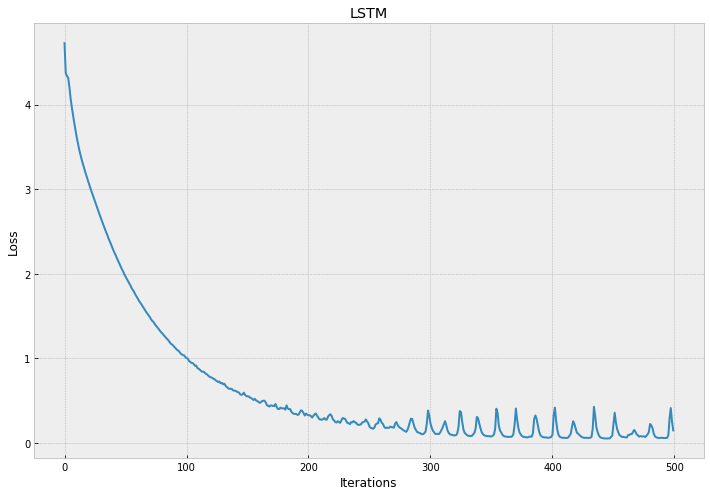

In [31]:
loss = model.history.history['loss']

plt.style.use('bmh')
plt.figure(figsize=(12, 8))
plt.plot(range(len(loss)), loss)
plt.title('LSTM')
plt.xlabel('Iterations')
plt.ylabel('Loss')

从上图看来，迭代次数可以控制在350~400，再仔细观察：

Text(0, 0.5, 'Loss')

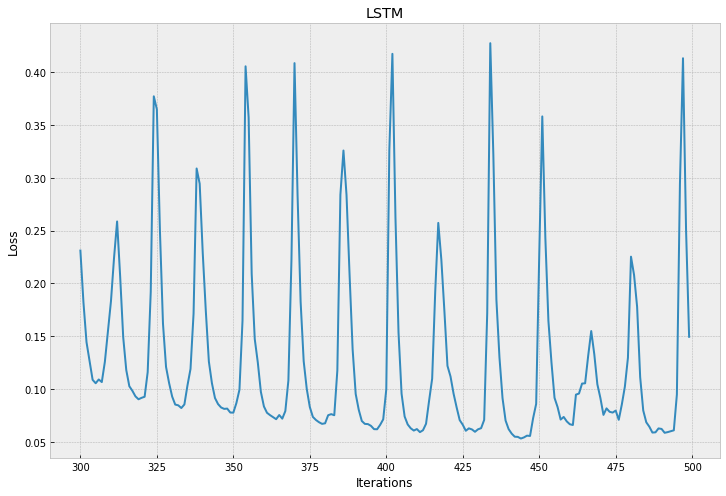

In [43]:
a = 300
b = 500
plt.figure(figsize=(12, 8))
plt.plot(range(a, b), loss[a: b])
plt.title('LSTM')
plt.xlabel('Iterations')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

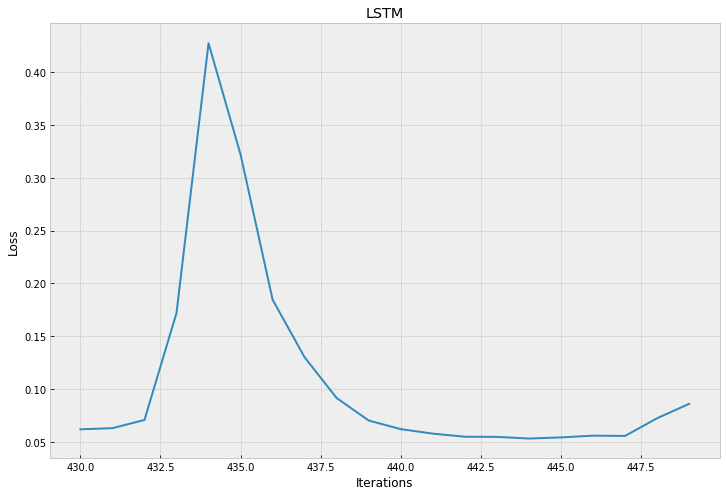

In [47]:
a = 430
b = 450
plt.figure(figsize=(12, 8))
plt.plot(range(a, b), loss[a: b])
plt.title('LSTM')
plt.xlabel('Iterations')
plt.ylabel('Loss')

然而并不需要这么仔细

## 预测

In [32]:
test_lrc = '当节奏开始转' # 输入歌词开头
test_sequence = tokenizer.texts_to_sequences(test_lrc) # 序列化
test_sequence = pad_sequences(test_sequence).reshape(1, -1)
test_sequence = pad_sequences(test_sequence, X.shape[1]) # 输入序列长度不足10，故使用pad_sequences将其补足
test_sequence

array([[  0,   0,   0,   0, 149, 374,   0,  38, 148, 131]], dtype=int32)

In [33]:
print('输出的最大下标为：', model.predict(test_sequence).argmax())

输出的最大下标为： 0


Tokenizer()中的字典是以1开始作为下标的，故我们将下标0看作是空格

In [34]:
try:
    print(tokenizer.index_word[0])
except:
    print('字典中没有')

字典中没有


我们需要让模型不断的输出，就要有一个不断输入的循环，将输出添加到原来的输入当中，于是就有了新的输入

In [35]:
test_lrc += ' ' # 下标为0，故添加一个空格
test_lrc

'当节奏开始转 '

新的汉字加进来后

In [36]:
test_sequence = tokenizer.texts_to_sequences(test_lrc)
test_sequence = pad_sequences(test_sequence).reshape(1, -1)
test_sequence = pad_sequences(test_sequence, X.shape[1])
test_sequence

array([[  0,   0,   0, 149, 374,   0,  38, 148, 131,   0]], dtype=int32)

### 函数形式

In [37]:
# 输入一个文本将其转化为序列
def input_sequence(text, max_len=10):
    sequence = tokenizer.texts_to_sequences(text) # 序列化
    sequence = pad_sequences(sequence).reshape(1, -1) # 填充0
    sequence = pad_sequences(sequence, maxlen=max_len) # 补足或截断
    return sequence

In [38]:
# 得到字典内的汉字
def next_word(y_pred):
    idx = np.argmax(y_pred) # 最大值的下标
    if idx == 0: # 下标为0时，字典内并不存在，故视为空格
        return ' '
    else:
        return tokenizer.index_word[idx]

输出长度为200的歌词试试看：

In [39]:
lrc = '当节奏开始转'
for i in range(200):
    X_sequence = input_sequence(lrc)
    y_pred = model.predict(X_sequence)
    word = next_word(y_pred)
    lrc += word
lrc = re.sub('\s+', ' ', lrc) # 只需要一个空格
print(lrc)

当节奏开始转 是否心里 这飞过 着边 着行满爱一变 心会感觉又会有前 喔 我的前吧 我只想要来 离的梦 你的高泪 却说以够 老远记向方真会忘掉 到不停此转生 一 依然明白 春人的春天的恋于离 力 那是唯一 这是十二个生 在乎我心爱不想用话 但看见你喜欢 头望 忘了一 大声 你在我心个欢的几次 带又后比任 好 断爱的 有言自头 有心 快出我用全部生的梦得痛 也不听见面 不如


然而我们并没有看懂他在讲什么

### 函数形式

In [40]:
def generating_lrc(lrc, length=200):
    for i in range(200):
        X_sequence = input_sequence(lrc)
        y_pred = model.predict(X_sequence)
        word = next_word(y_pred)
        lrc += word
    lrc = re.sub('\s+', ' ', lrc) # 只需要一个空格
    return lrc

In [41]:
generating_lrc('大城小爱')

'大城小爱 关不尽不 来 我不切会说过任 忘了话冷 给我眼中 春 的已 的打 带 我用生命好听清楚 在 了 看 这一场爱情 失陪你拉英雄我到 把 伤情就能回到永远 永远眼愿中 然不思 我怎能 星 音乐 好 你陪都知道你是我手就是你我心愿就在这里 了春去现在 上了时候 们来 在每个 伤心犯我的心情留 人就会变成为今天 你们是神 着 全世界带 季 那 过 地 花'

In [42]:
generating_lrc('他根本就不会用丹田唱歌')

'他根本就不会用丹田唱歌 根根本 根根根本 根根根本 他根本就不会用丹田唱歌 根根本 根根根本 根根根本 他根本就不会用丹田唱歌 根根本 根根根本 根根根本 他根本就不会用丹田唱歌 根根本 根根根本 根根根本 他根本就不会用丹田唱歌 根根本 根根根本 根根根本 他根本就不会用丹田唱歌 根根本 根根根本 根根根本 他根本就不会用丹田唱歌 根根本 根根根本 根根根本 他根本就不会用丹田唱歌 根根本 根根根本 根根根本 他根本'

# 参考资料

1. [Generating Drake Rap Lyrics using Language Models and LSTMs](https://towardsdatascience.com/generating-drake-rap-lyrics-using-language-models-and-lstms-8725d71b1b12)（译文：[使用Keras和LSTM生成说唱歌词](https://www.jqr.com/article/000236)）
2. [序列预处理 - Keras中文文档](https://keras.io/zh/preprocessing/sequence/)
3. [嵌入层 Embedding - Keras中文文档](https://keras-cn.readthedocs.io/en/latest/layers/embedding_layer/)
4. [损失函数 Losses - Keras中文文档](https://keras.io/zh/losses/)
5. [深度学习中Keras中的Embedding层的理解与使用](http://frankchen.xyz/2017/12/18/How-to-Use-Word-Embedding-Layers-for-Deep-Learning-with-Keras/)